In [ ]:
import jax
import pgx
from pgx.experimental import act_randomly
import random
from pgx.leduc_holdem import State

env = pgx.make("leduc_holdem")

init = jax.jit(jax.vmap(env.init))  # vectorize and JIT-compile
step = jax.jit(jax.vmap(env.step))
act_randomly = jax.jit(act_randomly)

batch_size = 1
i_steps = 0


In [116]:
from __future__ import annotations
from collections import Counter
from dataclasses import dataclass
import itertools
from typing import Literal
from copy import deepcopy
import jax.numpy as jnp
import numpy as np

cards = [0, 1, 2]  # J, Q, K (ranks: 0<J<1<Q<2<K)
deck = [0, 0, 1, 1, 2, 2]

CALL = 0
RAISE = 1
FOLD = 2
actions = np.array([CALL, RAISE, FOLD])
action_names = {
    CALL: "call",
    RAISE: "raise",
    FOLD: "fold"
}

@dataclass
class Node:
    node_type: Literal["chance", "player", "terminal"]
    state: State | None = None
    action_taken: int | None = None # action that led to this node (from parent)
    actual_prob: float = 1.0  # environment probability of going to this node
    percieved_prob_p0: float = 1.0  # environment probability of going to this node from player's 0 perspective
    percieved_prob_p1: float = 1.0  # environment probability of going to this node from player's 1 perspective
    reward_p0: float | None = None # terminal reward from player 0 perspective
    children: list[Node] = None
    observation: np.ndarray | None = None

    def __post_init__(self):
        if self.children is None:
            self.children = []

    def get_child_with_action(self, action: int) -> Node | None:

        for c in self.children:
            if c.action_taken == action:
                return c
        
        return None
    
    def get_infostate_key(self) -> tuple[bool, ...]:
        
        assert self.state is not None, "None state"
        
        return tuple(self.observation.tolist())

TRUE = jnp.bool_(True)
def observe(state: State, player_id) -> jnp.ndarray:
    """
    Copied from pgx leduce poker

    Index   Meaning
    0~3     J ~ K in hand
    3~6     J ~ K as public card
    6~20    0 ~ 13 chips for the current player
    20~34   0 ~ 13 chips for the opponent
    34~37   0 ~ 2 number of raises in the round
    """
    obs = jnp.zeros(37, dtype=jnp.bool_)
    obs = obs.at[state._cards[0][player_id]].set(TRUE)
    obs = jax.lax.select(state._round[0] == 1, obs.at[3 + state._cards[0][2]].set(TRUE), obs)
    obs = obs.at[6 + state._chips[0][player_id]].set(TRUE)
    obs = obs.at[20 + state._chips[0][1 - player_id]].set(TRUE)
    obs = obs.at[34 + state._raise_count[0]].set(TRUE)
    return obs

def all_private_deals() -> list[tuple[int, int, float, float, float]]:

    perms = list(itertools.permutations(deck, 2))
    combos = Counter(perms)
    all_n = len(deck) * (len(deck) - 1)

    out = []
    for (c0, c1), count in combos.items():
        out.append((c0, c1, count / all_n, 1/3, 1/3))
    return out


def all_board_deals(state: State) -> list[tuple[int, float, float, float]]:
    
    p0_card = state._cards[0][0]
    p1_card = state._cards[0][1]

    current_deck = deck.copy()
    
    assert p0_card in current_deck
    assert p1_card in current_deck

    current_deck.remove(p0_card)
    current_deck.remove(p1_card)
    
    remain_cards = len(current_deck)
    current_deck = Counter(current_deck)

    out = []
    for card, count in current_deck.items():

        p0 = 1/5 if p0_card == card else 2/5
        p1 = 1/5 if p1_card == card else 2/5

        out.append((card,  count / remain_cards, p0, p1))
    return out

def expand_player_node(node: Node):

    
    state = node.state
    node.observation = np.array(observe(state, state.current_player[0]))

    for action, legal in zip(actions, state.legal_action_mask[0], strict=True):

        if not legal:
            continue

        s_next: State = step(state, jnp.array([action]))
        child = Node(node_type="unknown", state=s_next, action_taken=action)
        node.children.append(child)

        terminated, truncated = s_next.terminated[0], s_next.truncated[0]

        if not terminated and truncated:
            raise RuntimeError("not terminated but truncated")
        
        if terminated:
            # End
            child.node_type = "terminal"
            child.reward_p0 = s_next.rewards[0][0]
        elif (state._round[0] == 0) and (s_next._round[0] == 1):
            # Round transition
            child.node_type = "chance"
            expand_board_card(child)
        else:
            # Player node
            child.node_type = "player"
            expand_player_node(child)



def expand_board_card(node: Node):
    
    state = node.state

    for board_card, env_p, p0_p, p1_p in all_board_deals(node.state):

        next_state: State = node.state.replace(
            _cards = jnp.array([[state._cards[0][0], state._cards[0][1], board_card]])
        )

        child = Node(
            node_type="player",
            actual_prob=env_p,
            state=next_state,
            percieved_prob_p0=p0_p,
            percieved_prob_p1=p1_p
        )

        expand_player_node(child)

        node.children.append(child)
    
    
    # Chance node has invalid observation so we need to delete it
    node.state = None

def build_full_tree():

    key = jax.random.PRNGKey(random.randint(0, 100_000))
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, batch_size)
    state: State = init(keys) 

    assert state.rewards.shape[0] == 1

    root = Node(
        node_type="chance",
        state=None
    )

    for p0_card, p1_card, env_prob_deal, p0_prob_deal, p1_prob_deal in all_private_deals():
        for player_start, prob_start in zip([0, 1], [0.5, 0.5]):

            env_prob = env_prob_deal * prob_start
            p0_prob = p0_prob_deal * prob_start
            p1_prob = p1_prob_deal * prob_start

            next_state = state.replace(
                _first_player = jnp.array([player_start]),
                _cards = jnp.array([[p0_card, p1_card, -1]])
            )

            player_node = Node(
                node_type="player",
                state=next_state,
                actual_prob=env_prob,
                percieved_prob_p0=p0_prob,
                percieved_prob_p1=p1_prob
            )
            expand_player_node(player_node)
            root.children.append(player_node)

    return root
            

root = build_full_tree()

In [117]:

n_player_nodes_round_0 = 0
n_player_nodes_round_1 = 0
def check_every_player_has_valid_observation(n: Node):
    global n_player_nodes_round_0, n_player_nodes_round_1

    if n.node_type == "terminal":
        return
    
    if n.node_type == "player":
    
        s = n.state

        assert n.observation.sum() > 0, f"sum {n.observation}"

        if s._round[0] == 1:
            n_player_nodes_round_1 += 1
            assert (n.observation[3:6].sum() == 1),  f"round 1 and sum = {n.observation[3:6].sum()}"
        else:
            n_player_nodes_round_0 += 1
    
    for c in n.children:
        check_every_player_has_valid_observation(c)

check_every_player_has_valid_observation(root)
n_player_nodes_round_0, n_player_nodes_round_1

(108, 1440)

In [118]:

_check = dict()

def kokot(o_s):
    print(f"player={o_s.current_player}, step={o_s._step_count}, first={o_s._first_player}, "
          f"cards={o_s._cards}, last_act={o_s._last_action}, chips={o_s._chips}, "
          f"round={o_s._round}, raises={o_s._raise_count}")
    
def pretty_observation(obs):
    print(obs.shape)
    h = ["J","Q","K","A"][int(jnp.argmax(obs[:4]))]
    p = ["J","Q","K"][int(jnp.argmax(obs[3:6]))] if obs[3:6].any() else "-"
    mc = jnp.argmax(obs[6:20]).item()
    oc = jnp.argmax(obs[20:34]).item()
    rc = jnp.argmax(obs[34:37]).item()
    
    return f"hand={h}, public={p}, my_chips={mc}, opp_chips={oc}, raise={rc}"

def check_bijective_infostate_legal_actions(n: Node):

    if n.node_type == "terminal":
        return
    
    if n.node_type == "player":
    
        k = n.get_infostate_key()
        incoming_legal = n.state.legal_action_mask
        incoming_observation = n.observation
        incoming_state = n.state

        if k in _check:

            original_observation, original_legal, original_state = _check[k]
            
            ok = (original_legal == incoming_legal).all()

            if not ok:

                kokot(original_state)
                kokot(incoming_state)

                print(f"Legal o={original_legal}")
                print(f"Legal i={incoming_legal}")

                print(f"Obs o={pretty_observation(original_observation)}")
                print(f"Obs i={pretty_observation(incoming_observation)}\n\n")

        else:
            _check[k] = (incoming_observation, incoming_legal, incoming_state)

    for c in n.children:
        check_bijective_infostate_legal_actions(c)

check_bijective_infostate_legal_actions(root)

100%|██████████| 10000/10000 [04:49<00:00, 34.53it/s]


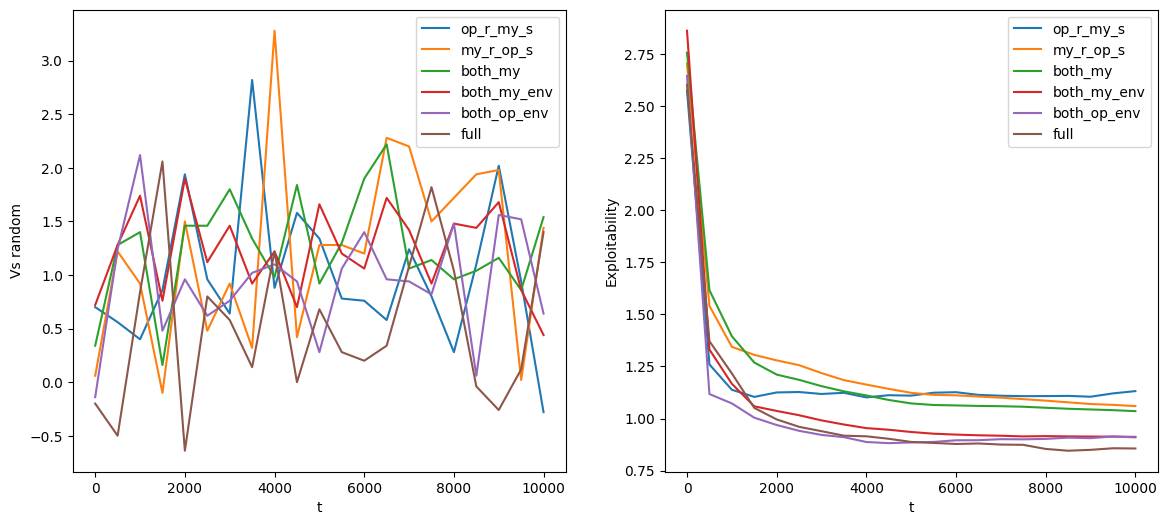

In [149]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

# my, op, env
STRUE = True
weighting_specs = {
    "op_r_my_s": {
        "r": [False, STRUE, False],
        "s": [STRUE, False, False],
    },
    "my_r_op_s": {
        "r": [STRUE, False, False],
        "s": [False, STRUE, False],
    },
    "both_my": {
        "r": [STRUE, False, False],
        "s": [STRUE, False, False],
    },
    "both_my_env": {
        "r": [STRUE, False, STRUE],
        "s": [STRUE, False, STRUE],
    },
    "both_op_env": {
        "r": [False, STRUE, STRUE],
        "s": [False, STRUE, STRUE],
    },
    "full": {
        "r": [STRUE, STRUE, STRUE],
        "s": [STRUE, STRUE, STRUE],
    }
}

weighting: str | None = None

@dataclass
class Info:

    legal_actions: np.ndarray
    observation: np.ndarray
    
    n: int = -1
    strategy: np.ndarray | None = None
    cumulative_strategy: np.ndarray | None = None
    uniform: np.ndarray  | None = None
    cumulative_regret: np.ndarray | None = None
    policy: np.ndarray | None = None

    average_regret: np.ndarray | None = None
    _steps: int = 0


    def __post_init__(self):
        
        n = int(self.legal_actions.size)
        self.n = n

        if self.strategy is None:
            self.strategy = np.ones(n) / n
            self.uniform = np.ones(n) / n
        
        if self.cumulative_regret is None:
            self.cumulative_regret = np.zeros(n)

        if self.cumulative_strategy is None:
            self.cumulative_strategy = np.zeros(n)

        if self.policy is None: 
            self.policy = np.copy(self.uniform)

        self.average_regret = np.zeros(n)
        
    def update_avg_rerget(self, inst_regret: np.ndarray):

        self._steps += 1
        self.average_regret += (inst_regret - self.average_regret)
   

def get_infostate(node: Node, infoset: dict[tuple[bool], Info]) -> tuple[Info, np.ndarray]:

    legal_actions = np.array([a for a, l in zip(actions, node.state.legal_action_mask[0], strict=True) if l])

    o = node.observation
    key = node.get_infostate_key()

    if key not in infoset:
        infoset[key] = Info(legal_actions, o)

    info = infoset[key]
    return info, legal_actions
    

def aw(p: float, apply: bool) -> float:
    return p if apply else 1.0


def CFR(infoset: dict[tuple[bool], Info], n: Node, i: int, t: int, pi_1: float = 1.0, pi_2: float = 1.0, p_c: float = 1.0):

    if n.node_type == "terminal":
        return n.reward_p0 if i == 0 else -n.reward_p0
    elif n.node_type == "chance":
        prob = np.array([c.actual_prob for c in n.children])
        i_child = np.random.choice(len(n.children), p=prob)
        child = n.children[i_child]
        return CFR(infoset, child, i, t, pi_1, pi_2, p_c * prob[i_child])
        # v = 0.0
        # for child in n.children:
        #     p = child.actual_prob
        #     v += p * CFR(child, i, t, pi_1, pi_2)
        # return v
    
    info, actions = get_infostate(n, infoset)
    value_total = 0
    value_action = np.zeros(info.n)
    current_player = n.state.current_player[0]
    
    for i_action, action in enumerate(actions):
        
        p_action = info.strategy[i_action]
        child = n.get_child_with_action(action)
        assert child is not None

        if current_player == 0:    
            value_action[i_action] = CFR(infoset, child, i, t, p_action * pi_1, pi_2, p_c)
        elif current_player == 1:
            value_action[i_action] = CFR(infoset, child, i, t, pi_1, p_action * pi_2, p_c)
        else:
            raise ValueError(current_player)
        
        value_total += p_action * value_action[i_action]

    if current_player == i:
        
        inst_regret = (value_action - value_total)
        info.update_avg_rerget(inst_regret)

        pi_i = pi_1 if i == 0 else pi_2  
        pi_minus_i = pi_1 if i != 0 else pi_2  

        specs = weighting_specs[weighting]
        rw_my, rw_op, rw_env = specs["r"] 
        sw_my, sw_op, sw_env = specs["s"]
        
        weight_regret = aw(pi_i, rw_my) * aw(pi_minus_i, rw_op) * aw(p_c, rw_env)
        weight_strategy = aw(pi_i, sw_my) * aw(pi_minus_i, sw_op) * aw(p_c, sw_env)

        # Vectorized
        info.cumulative_regret += weight_regret * (value_action - value_total)
        info.cumulative_strategy += weight_strategy * info.strategy

        # Update strategy
        R_plus = np.maximum(info.cumulative_regret, 0)
        denominator = np.sum(R_plus)

        if denominator > 0:
            info.strategy = R_plus / denominator
        else:
            info.strategy = np.copy(info.uniform)

        # CFR+
        info.cumulative_regret = R_plus
        

    return value_total


def compute_strategy_profile(infoset: dict[tuple[bool], Info]):
    for info in infoset.values():
        denom = np.sum(info.cumulative_strategy)
        if denom == 0:
            info.policy = np.copy(info.uniform)
        else:
            info.policy = info.cumulative_strategy / denom


def play_strategy(observation: jnp.ndarray, infoset: dict[tuple[bool], Info]) -> jnp.ndarray:

    key = tuple(observation.squeeze().tolist())
    info = infoset[key]

    action = info.legal_actions[np.random.choice(info.n, p=info.policy)]
    return jnp.array([action])

def vs_random(infoset: dict[tuple[bool], Info]) -> float:

    rewards = []

    for _ in range(50):

        key = jax.random.PRNGKey(random.randint(0, 100_000))
        key, subkey = jax.random.split(key)
        keys = jax.random.split(subkey, batch_size)

        state = init(keys)
        while not (state.terminated | state.truncated).all():
            key, subkey = jax.random.split(key)

            if state.current_player[0] == 0:
                action = play_strategy(observe(state, jnp.int32(0)), infoset)
            else:
                action = act_randomly(subkey, state.legal_action_mask)
        
            state = step(state, action)  # state.reward (2,)

        rewards.append(state.rewards[0][0])
    
    return np.mean(rewards)
        
def best_response_value(infoset: dict[tuple[bool], Info] , node: Node, br_player: int, pi_1=1.0, pi_2=1.0) -> float:
    if node.node_type == "terminal":
        return node.reward_p0 if br_player == 0 else -node.reward_p0

    elif node.node_type == "chance":
        prob = np.array([c.actual_prob for c in node.children])
        value = 0.0
        for p, child in zip(prob, node.children):
            value += p * best_response_value(infoset, child, br_player, pi_1, pi_2)
        return value

    info, actions = get_infostate(node, infoset)
    current_player = node.state.current_player[0]

    if current_player == br_player:
        # This player chooses the action with highest expected value (best response)
        values = np.array([best_response_value( infoset,
            node.get_child_with_action(a), br_player, pi_1, pi_2
        ) for a in actions])
        return np.max(values)
    else:
        # Opponent follows fixed average strategy
        strat = info.policy
        value = 0.0
        for p, a in zip(strat, actions):
            child = node.get_child_with_action(a)
            value += p * best_response_value(infoset, child, br_player, pi_1, pi_2)
        return value

def compute_exploitability(infoset: dict[tuple[bool], Info], root: Node):
    return best_response_value(infoset, root, br_player=0)

def solve() -> tuple[list, list, list]:

    infoset: dict[tuple[bool], Info] = dict()

    vss = []
    exploits = []
    steps = []

    t_max = 10_000
    for t in tqdm.tqdm(list(range(t_max))):

        for i in range(2):
            CFR(infoset, root, i, t)

        if t % 500 == 0 or t == (t_max - 1):
            compute_strategy_profile(infoset)
            
            e = compute_exploitability(infoset, root)
            exploits.append(e)

            vs = vs_random(infoset)
            vss.append(vs)
            steps.append(t)
            
            # print(f"vs_random={vs:.3f}, epsilon={e:.3f}")

    compute_strategy_profile(infoset)
    return steps, vss, exploits

def grid_search():
    global weighting

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    for name in weighting_specs.keys():
        
        weighting = name
        steps, vss, exploits = solve()

        ax[0].plot(steps, vss, label=name)
        ax[1].plot(steps, exploits, label=name)

    ax[0].set_ylabel("Vs random")
    ax[0].set_xlabel("t")
    ax[0].legend()
    
    ax[1].set_ylabel("Exploitability")
    ax[1].set_xlabel("t")
    ax[1].legend()
    
    plt.show()

grid_search()

In [ ]:
# if J:   J, Q, Q, K, K
# J: 1/5
# Q: 2/5

Obs = 
row = tuple[]

def minmax(n: Node, dataset: list[]):
    ...

def solve_weighted_minmax():
    ...


In [44]:
key = jax.random.PRNGKey(random.randint(0, 100_000))
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, batch_size)
state = init(keys)
state.observation.shape

(1, 34)

In [6]:
[key for key in dir(state) if (not key.startswith("__"))]

['_abc_impl',
 '_cards',
 '_chips',
 '_first_player',
 '_flax_dataclass',
 '_last_action',
 '_raise_count',
 '_repr_html_',
 '_round',
 '_step_count',
 'current_player',
 'env_id',
 'legal_action_mask',
 'observation',
 'replace',
 'rewards',
 'save_svg',
 'terminated',
 'to_svg',
 'truncated']